In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy.engine import create_engine
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import boto3
from io import StringIO
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
import os

train_path = "s3://sagemaker-us-east-1-381492296191/cardio_data/cardio_train_split40%.csv"
df_train = pd.read_csv(train_path)

print(df_train.shape)
df_train.head()

(27355, 21)


,bmi,pulse_pressure,chol_bmi_ratio,age_gluc_interaction,age_years,bp_category,bmi_category,age_group,age,gender,...,diastolic_bp,cholesterol,gluc,smoke,alco,active,cholesterol_label,is_hypertensive,lifestyle_score,cardio
0,0.356252,-1.333102,-0.663493,-0.607015,-1.157121,0.0,2.0,2.0,45,1,...,70,1,1,0,0,1,Normal,0,-1,0
1,-0.856304,-0.463056,-0.274939,-0.727588,-1.748137,2.0,1.0,2.0,41,2,...,80,1,1,1,0,1,Normal,0,0,1
2,3.640258,-0.463056,-1.172217,-0.426156,-0.270596,2.0,3.0,3.0,51,1,...,90,1,1,0,0,1,Normal,0,-1,1
3,-0.826364,-0.463056,-0.286956,-0.275441,0.468174,2.0,1.0,3.0,56,1,...,80,1,1,0,0,1,Normal,0,-1,0
4,0.350638,0.406991,-0.659487,-0.396013,-0.122842,2.0,2.0,3.0,52,2,...,80,1,1,0,0,1,Normal,0,-1,1


In [4]:
#  Train a simple Logistic Regression Model

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Define features and target
X = df_train.drop(columns=['cardio'])
y = df_train['cardio']

# Encode non-numeric columns
X = pd.get_dummies(X)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.82      0.75      2764
           1       0.78      0.63      0.69      2707

    accuracy                           0.72      5471
   macro avg       0.73      0.72      0.72      5471
weighted avg       0.73      0.72      0.72      5471



### Model Evaluation Interpretation
### Classification Report
    * Class 0:
        * Precision: 0.69 — ~69% of predicted "no disease" cases are correct.
        * Recall: 0.82 — ~82% of all actual "no disease" cases were correctly identified.
        * F1-score: 0.75 — A good balance, skewed slightly toward identifying negatives.
    * Class 1:
        * Precision: 0.78 — High precision in predicting disease (fewer false positives).
        * Recall: 0.63 — Recall is lower, indicating some false negatives (missed predictions).
        * F1-score: 0.69 — Acceptable but shows potential for improvement.
## Overall Accuracy: 72%
    This is a strong benchmark for a simple logistic regression model with minimal tuning.

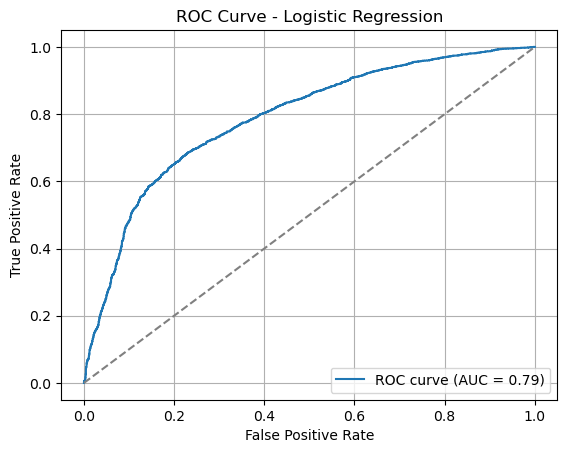

In [5]:
#  ROC Curve and AUC

from sklearn.metrics import roc_curve, auc

y_prob = model.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### ROC Curve (AUC = 0.79)
    * AUC of 0.79 indicates good discrimination ability.
    * The model performs much better than random guessing (which would have an AUC of 0.5).
    * AUC close to 0.8 is promising for a baseline model.

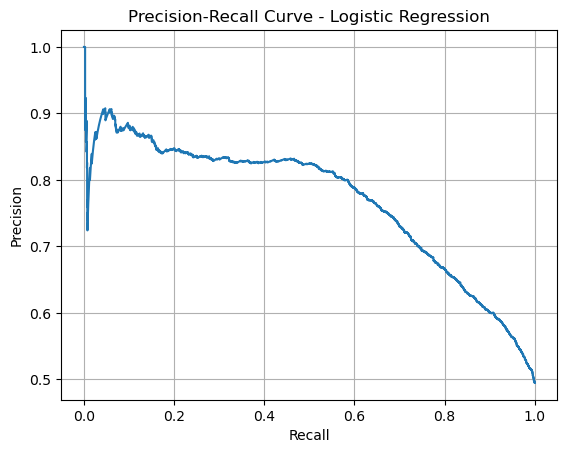

In [8]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_val, y_prob)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.grid(True)
plt.show()

### Precision-Recall Curve
    * Shows high precision at low recall, which gradually declines.
    * Indicates that as we try to identify more positive cases, precision drops.
    * Useful if you need to balance false positives/negatives differently depending on the application.

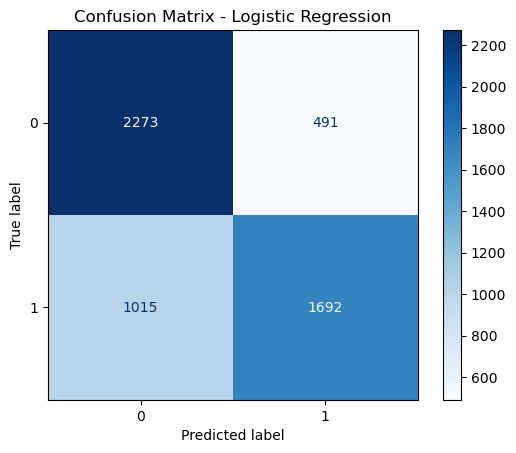

In [9]:
# Confusion Matrix

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

### Confusion Matrix
    * True Negatives (2273): Correctly predicted no disease.
    * False Positives (491): Predicted disease, but actually healthy.
    * False Negatives (1015): Missed actual disease cases.
    * True Positives (1692): Correctly predicted disease.
This shows that the model is slightly better at predicting negatives (non-disease cases), but also captures a fair number of true positives.